In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
# %matplotlib inline

import pyquil.quil as pq
import pyquil.api as api
from pyquil.gates import H, X, CPHASE00
# from pyquil import Program
# from pyquil.gates import H, X, CPHASE00
# from pyquil.api import WavefunctionSimulator

Here we perform a continuous time quantum walk (CTQW) on a complete graph with four nodes (denoted as $K_4$). We will be following [this](https://www.nature.com/articles/ncomms11511) paper.

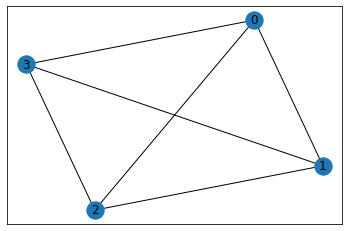

In [2]:
# create a graph
G = nx.complete_graph(4)
nx.draw_networkx(G)

The spectrum of complete graphs is quite simple -- one eigenvalue equal to $N-1$ (where $N$ is the number of nodes) and the remaining equal to -1:

In [3]:
# Diagonalize the adjacency matrix
A = nx.adjacency_matrix(G).toarray()
eigvals, _ = np.linalg.eigh(A)
print("Eigenvalues = ", eigvals)

Eigenvalues =  [-1. -1. -1.  3.]


For the CTQW the usual hamiltonian is the adjacency matrix $A$. We modify it slightly by adding the identity, i.e. we take $\mathcal{H} = A + I$. This will reduce the number of gates we need to apply, since the eigenvectors with 0 eigenvalue will not acquire a phase.

In [4]:
# Get the Hamiltonian
hamil = A + np.eye(4)

It turns out that $K_n$ graphs are Hadamard diagonalizable, allowing us to write $\mathcal{H} = Q \Lambda Q^\dagger$, where $Q = H \otimes H$. Let's check that this works.

In [5]:
# Hadamard gate
hgate = np.sqrt(1/2) * np.array([[1, 1], [1, -1]])
# pauli_x = np.array([[0, 1], [1, 0]])
hgate

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [6]:
# Form the matrix Q = H \otimes H to diagonalize the Hamiltonian
Q = np.kron(hgate, hgate) # Kronecker product

# complex conjugate, element-wise. The complex conjugate of a complex number is obtained by changing the sign of its imaginary part.
Q.conj().T.dot(hamil).dot(Q)

array([[ 4.00000000e+00, -4.93038066e-32, -4.93038066e-32,
         4.93038066e-32],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

The time evolution operator $e^{-iHt}$ is also diagonalized by the same transformation. In particular we have

$$
Q^\dagger e^{-iHt}Q = \begin{pmatrix} 
            e^{-i4t} & 0 & 0 & 0 \\
            0 & 1 & 0 & 0 \\
            0 & 0 & 1 & 0 \\
            0 & 0 & 0 & 1
           \end{pmatrix}
$$

Which is just a [CPHASE00](http://pyquil.readthedocs.io/en/latest/gates.html) gate with an angle of $-4t$. The circuit to simulate these is then extremely simple:

![](circuit.png "Circuit for $K_4$ CTQW")

(Taken from paper above, $\gamma = 1$ in our case.)

In [7]:
# Function for the continuous time quantum walk circuit on a complete graph
def k_4_ctqw(t):
    """Returns a program implementing a continuous time quantum walk."""
    prog = pq.Program()

    # Change to diagonal basis
    prog.inst(H(0))
    prog.inst(H(1))

    # Time evolve
    prog.inst(CPHASE00(-4*t, 0, 1))
    
    # Change back to comutational basis
    prog.inst(H(0))
    prog.inst(H(1))

    return prog

Let's compare the quantum walk with a classical random walk. The classical time evolution operator is $e^{-(\mathcal{M} - I) t}$ where $\mathcal{M}$ is the transition matrix of the graph.

We choose as our initial condition $|\psi(0)> = |0>$, that is the walker starts on the first node. Therefore, due to symmetry, the probability of occupation of all nodes besides $| 0 >$ is the same. 

In [8]:
# Stochastic transition matrix for classical walk
M = A / np.sum(A, axis=0)

# Set up time to simulate for
tmax = 4
steps = 40
time = np.linspace(0, tmax, steps)

# Arrays to hold quantum probabilities and classical probabilities at each time
quantum_probs = np.zeros((len(time), 4))
classical_probs = np.zeros((len(time), 4))

In [9]:
from pyquil.api import WavefunctionSimulator

qvm = WavefunctionSimulator()

In [10]:
# Do the classical and quantum continuous-time walks

for i, t in enumerate(time):
    # Get a quantum program
    prog = k_4_ctqw(t)  
    
    # Simulate the circuit and store the probabilites
    wvf = qvm.wavefunction(prog)
    vec = wvf.amplitudes
    quantum_probs[i] = np.abs(vec)**2

    # Do the classical continuous time walk
    classical_ev = expm((M-np.eye(4))*t)
    classical_probs[i] = classical_ev[:, 0]    
    


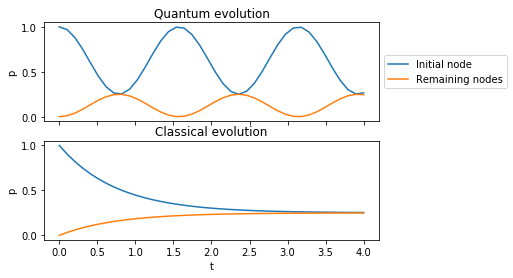

In [11]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.set_title("Quantum evolution")
ax1.set_ylabel('p')
ax1.plot(time, quantum_probs[:, 0], label='Initial node')
ax1.plot(time, quantum_probs[:, 1], label='Remaining nodes')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_title("Classical evolution")
ax2.set_xlabel('t')
ax2.set_ylabel('p')
ax2.plot(time, classical_probs[:, 0], label='Initial node')
ax2.plot(time, classical_probs[:, 1], label='Remaining nodes')